# SPDE with variable anisotropy

<!-- SUMMARY: Estimation and Simulations with non-stationary anisotropy of the Covariance Model, treated in the SPDE formalism -->

<!-- CATEGORY: SPDE -->

In this tutorial, we show how the use of SPDE for Varying Anisotropy in the Simulation process

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from pyrtid.utils import NDArrayFloat
from matplotlib.patches import Ellipse
from sksparse.cholmod import cholesky

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

Defining some global parameters

In [2]:
# Grid
nx = 140  # number of voxels along the x axis + 4 * 2 for the borders (regularization)
ny = 1
nz = 34  # number of voxels along the z axis
dx = 5.0  # voxel dimension along the x axis
dy = 80.0
dz = 1.0  # voxel dimension along the z axis


nx = 500
nz = 200

sill = 150**2

# Well Definition
nwell = 6
vlag = 3

# Anisotropy ratio
_ratio = 1.5
_range = 150

# Some seeds
seed1 = 34556643
seed2 = 244212
seednc = 432432
seedw = 2432145

# Color Scale
zlim = [-1.6, 2.5]

nostatKeys = ["A", "R2"]

# Graphic scale
gp.setDefault(dims=[10, 7])

Internal function

In [3]:
def make_well(db, res, nwell=nwell, vlag=vlag, seed=seedw):
    nx = res.getNX(0)
    indexes = gl.VectorHelper.sampleRanks(ntotal=nx, number=nwell, seed=seed, optSort=1)

    x1 = np.ones(0)
    x2 = np.ones(0)
    for i in indexes:
        bot = math.ceil(db.getValue("bot_limit_z", i))
        top = math.floor(db.getValue("top_limit_z", i))
        temp = np.arange(bot, top, step=vlag)
        x1 = np.concatenate((x1, i * np.ones(len(temp), dtype=int) + 0.2))
        x2 = np.concatenate((x2, temp))

    db_sample = gl.Db.createFromSamples(
        len(x1), gl.ELoadBy.COLUMN, np.concatenate((x1, x2))
    )
    db_sample.setName("New.1", "x1")
    db_sample.setName("New.2", "x2")
    db_sample.setLocator("x1", gl.ELoc.X, 0)
    db_sample.setLocator("x2", gl.ELoc.X, 1)
    err = gl.migrate(res, db_sample, "*simu*")
    return db_sample

Simulating the layer boundaries

In [4]:
db = gl.DbGrid.create(nx=nx)
model = gl.Model.createFromParam(gl.ECov.GAUSSIAN, range=200, space=gl.SpaceRN(1))
err = gl.simtub(
    None,
    dbout=db,
    model=model,
    nbtuba=1000,
    seed=seed1,
    namconv=gl.NamingConvention("bot_limit_z"),
)
err = gl.simtub(
    None,
    dbout=db,
    model=model,
    nbtuba=1000,
    seed=seed2,
    namconv=gl.NamingConvention("top_limit_z"),
)
db["bot_limit_z"] = db["bot_limit_z"] - min(db["bot_limit_z"])
db["top_limit_z"] = db["top_limit_z"] - min(db["top_limit_z"])
db["top_limit_z"] = db["bot_limit_z"] + db["top_limit_z"] + 1
db["bot_limit_z"] = nz * db["bot_limit_z"] / max(db["top_limit_z"])
db["top_limit_z"] = nz * db["top_limit_z"] / max(db["top_limit_z"])
db["limit_average_z"] = (db["top_limit_z"] + db["bot_limit_z"]) / 2
db.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 1
Number of Columns            = 5
Total number of samples      = 500

Grid characteristics:
---------------------
Origin :      0.000
Mesh   :      1.000
Number :        500

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = bot_limit_z - Locator = NA
Column = 3 - Name = top_limit_z - Locator = z1
Column = 4 - Name = limit_average_z - Locator = NA
 

Plotting the limits of the layer

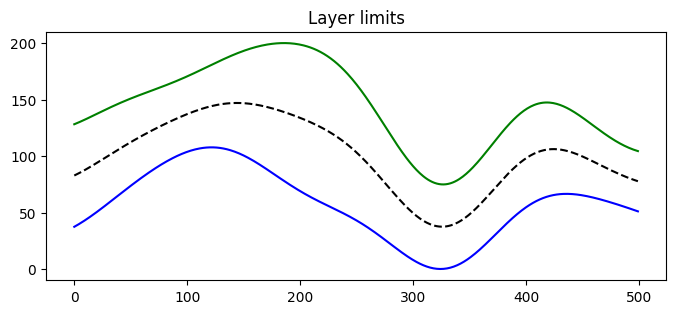

In [5]:
ax = gp.grid1D(db, name="bot_limit_z", color="blue")
ax = gp.grid1D(db, name="top_limit_z", color="green")
ax = gp.grid1D(db, name="limit_average_z", color="k", linestyle="--")
ax.decoration(title="Layer limits")

In [6]:
# Compute the angle of the top limit
angle_top = np.arctan(db["bot_limit_z"][1:] - db["bot_limit_z"][:-1]) / np.pi * 180
angle_top = np.insert(angle_top, 0, angle_top[0])  # first angle is zero

# Compute the angle of the bottom limit
angle_bot = np.arctan(db["top_limit_z"][1:] - db["top_limit_z"][:-1]) / np.pi * 180
angle_bot = np.insert(angle_bot, 0, angle_bot[0])  # first angle is zero

# Create a model
model = gl.Model.createFromParam(
    gl.ECov.BESSEL_K, range=_range, param=1, space=gl.SpaceRN(2), sill=sill
)

# CReate the grid
dbgrid = gl.DbGrid.create([nx, nz])

# indices of the grid
ind = (dbgrid["x1"]).reshape(1, -1)[0].astype(int)
# create a selection inside the model
dbgrid["sel"] = (dbgrid["x2"] > db[ind, "bot_limit_z"]) & (
    dbgrid["x2"] < db[ind, "top_limit_z"]
)

aniso = (dbgrid["x2"] - db[ind, "bot_limit_z"]) / (
    db[ind, "top_limit_z"] - db[ind, "bot_limit_z"]
)
aniso = angle_top[ind] + aniso * (angle_bot[ind] - angle_bot[ind])
ratio = (
    _ratio
    * (db[ind, "top_limit_z"] - db[ind, "bot_limit_z"])
    / max(db["top_limit_z"] - db["bot_limit_z"])
)

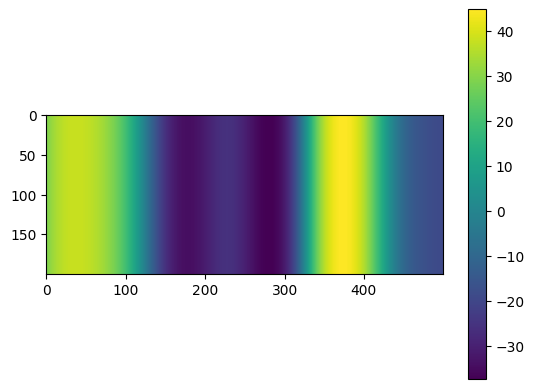

In [7]:
# aniso is in degrees
plt.imshow(aniso.reshape(nx, nz, order="F").T)
plt.colorbar()

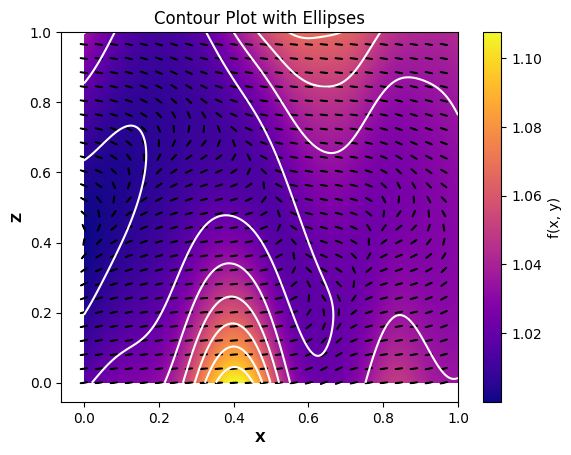

In [8]:
# Domain of study
xrange = [0, 1]
zrange = [0, 1]

# worm aspect -> quite fun
a = 0.5
b = 1.5

a = 0.03
b = 1.0

_top_limit_z = db["top_limit_z"] / nz
_bot_limit_z = db["bot_limit_z"] / nz
_limit_average_z = db["limit_average_z"] / nz
_thickness_z = _top_limit_z - _bot_limit_z


# Reference function: Contour lines define the angles of anisotropy
def f(x: float, y: float) -> float:
    return a * x + np.cosh((y - _limit_average_z) * b * _thickness_z)


# Symbolic gradient calculation
def gradf(x: float, y: float) -> NDArrayFloat:
    # return np.array([np.ones_like(x) * a - dcenterdx(x) * np.sinh((y - center(x))) / b, np.sinh((y - center(x))) / b])
    return np.array(
        [np.ones_like(x) * a, np.sinh((y - _limit_average_z)) * b * _thickness_z]
    )


# Angle calculation of contour lines (orthogonal to the gradient)
def thetaf(x: float, y: float):
    gf = gradf(x, y)
    return np.arctan2(gf[1], gf[0]) + np.pi / 2


# Ratio between axis lengths
def rhof(x: float, y: float):
    return np.ones_like(x) / 10


# Plot parameters
n_arrow_x = 25  # Resolution for ellipses
n_arrow_z = 25
arrow_scale_factor = 0.02  # Scale factor for ellipse representation

# Calculation of f on a grid
xseqGrid = np.linspace(xrange[0], xrange[1], 500)
yseqGrid = np.linspace(zrange[0], zrange[1], 200)
fGrid = np.array([f(xseqGrid, y) for y in yseqGrid]).T


# Calculation of ellipses on a grid
# xseqArrow = np.linspace(xrange[0], xrange[1], Narrow)
# yseqArrow = np.linspace(zrange[0], zrange[1], Narrow)
grid_coords = np.array(np.meshgrid(xseqGrid, yseqGrid)).T
arrow_grid_coords = grid_coords[
    :: int(nx / n_arrow_x), :: int(nz / n_arrow_z), :
].reshape(-1, 2, order="F")
rho_vec = (
    np.array([rhof(xseqGrid, y) for y in yseqGrid])
    .T[:: int(nx / n_arrow_x), :: int(nz / n_arrow_z)]
    .ravel("F")
)
theta_grid = np.degrees(
    np.array([thetaf(xseqGrid, y) for y in yseqGrid])
).T  # + aniso.reshape(nx, nz, order="F")
theta_vec = theta_grid[:: int(nx / n_arrow_x), :: int(nz / n_arrow_z)].ravel("F")

# Plot
plt.imshow(
    fGrid.T,
    cmap="plasma",
    extent=[xrange[0], xrange[1], zrange[0], zrange[1]],
    origin="lower",
    aspect="auto",
)
plt.colorbar(label="f(x, y)")

for i in range(len(arrow_grid_coords)):
    ellipse = Ellipse(
        xy=arrow_grid_coords[i],
        width=arrow_scale_factor,
        height=arrow_scale_factor * rho_vec[i],
        angle=theta_vec[i],
        facecolor="none",
        edgecolor="black",
    )
    plt.gca().add_patch(ellipse)

plt.contour(xseqGrid, yseqGrid, fGrid.T, colors="white")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Z", fontweight="bold")
plt.title("Contour Plot with Ellipses")
plt.show()

Creation of the varying anisotropy ("directed" by the two layers)

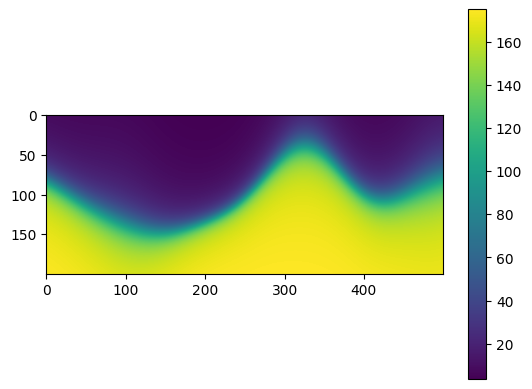

In [9]:
plt.imshow(theta_grid.reshape(nx, nz, order="F").T)
plt.colorbar()

In [10]:
aniso.shape

(100000,)

In [11]:
dbgrid.addColumns(theta_grid.ravel("F"), "aniso")
dbgrid.addColumns(ratio, "ratio")
# Add a mask over the space domain
dbgrid.setLocator("sel", gl.ELoc.SEL)
# Add anisotropies
dbgrid.setLocators(["aniso", "ratio"], gl.ELoc.NOSTAT)
dbgrid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 100000
Number of active samples     = 43700

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        500       200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = sel - Locator = sel
Column = 4 - Name = aniso - Locator = nostat1
Column = 5 - Name = ratio - Locator = nostat2
 

In [12]:
aniso.shape

(100000,)

In [13]:
dbgrid["x2"].shape

(100000,)

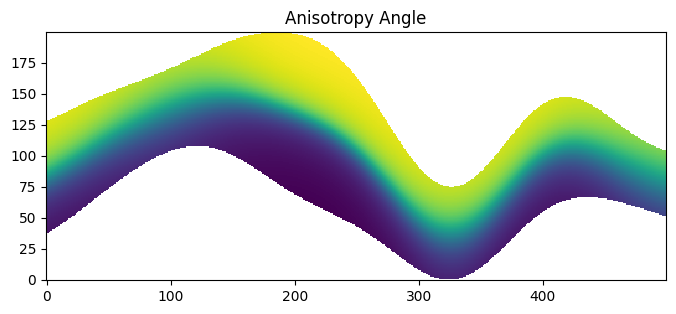

In [14]:
ax = dbgrid.plot("aniso")
ax.decoration(title="Anisotropy Angle")

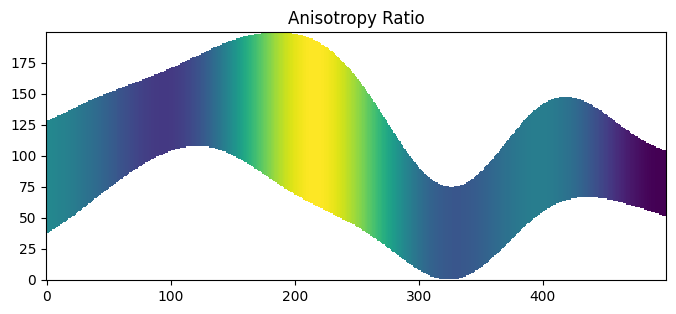

In [15]:
ax = dbgrid.plot("ratio")
ax.decoration(title="Anisotropy Ratio")

Display the anisotropy maps (on a coarser grid)

Creating the Meshing 

In [16]:
mesh = gl.MeshETurbo.createFromGrid(dbgrid, mode=0)

Assigning non-stationarity to the Model

In [17]:
dbcoarse = dbgrid.coarsify([20, 20])
nostat = gl.NoStatArray(nostatKeys, dbcoarse)
err = model.addNoStat(nostat)
model.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
K-Bessel (Third Parameter = 1)
- Sill         =  22500.000
- Range        =    150.000
- Theo. Range  =     43.301
Total Sill     =  22500.000

Non-Stationary Parameters
-------------------------
Angle      : GRF=1 Str=1 V#1=1
Range      : GRF=1 Str=1 V#1=2
 

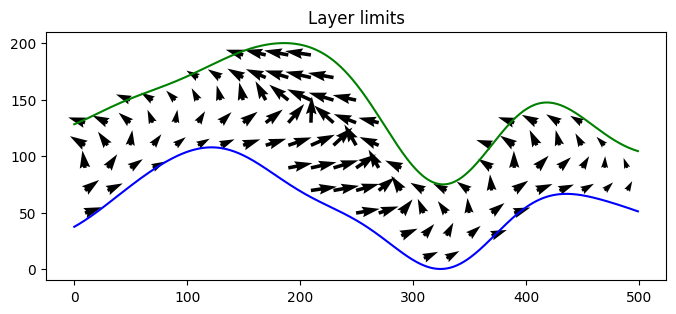

In [18]:
ax = gp.modelOnGrid(model=model, db=dbcoarse, scale=50, flagOrtho=False)
ax = gp.grid1D(db, name="bot_limit_z", color="blue")
ax = gp.grid1D(db, name="top_limit_z", color="green")
ax.decoration(title="Layer limits")

In [19]:
nostat = gl.NoStatArray(nostatKeys, dbgrid)
err = model.addNoStat(nostat)

## Non conditional simulation

In [20]:
# Create a model
# model_spde = gl.Model.createFromParam(
#     param=param, ranges=[250.0, 250.0], sill=sill
# )

# model_spde.addCovFromParam(gl.ECov.NUGGET, sill=nugget)

# model = gl.Model.createFromParam(gl.ECov.BESSEL_K,range=_range,param=1)

In [21]:
spdeRes = gl.SPDE(
    model=model,
    domain=dbgrid,
    data=None,
    calcul=gl.ESPDECalcMode.SIMUNONCOND,
    mesh=mesh,
)

- Extract the precision matrix

In [22]:
Q_nc = spdeRes.getPrecisionOpCs().getQToTriplet().toTL()
Q_nc

<43700x43700 sparse matrix of type '<class 'numpy.float64'>'
	with 816698 stored elements in Compressed Sparse Column format>

- Perform the cholesky factorization

In [23]:
# Decompose with cholesky
cholQ_nc = cholesky(Q_nc)

Process the simulation on the output grid and visualize the result (the resulting variable is stored in rank 'iuid' and name 'spde.simu'.

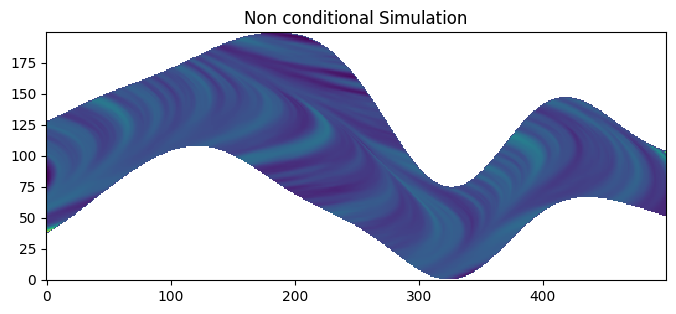

In [24]:
iuid = spdeRes.compute(dbgrid, namconv=gl.NamingConvention("spde.simu", False))
ax = dbgrid.plot("spde.simu")
ax.decoration(title="Non conditional Simulation")

In [25]:
from pyrtid.utils import indices_to_node_number

In [26]:
# we use the "sel" attribute to fill the grid
mask = dbgrid["sel"] != 0
ix_sel, iz_sel = np.array(np.meshgrid(np.arange(nx), np.arange(nz)))
sel_indices = indices_to_node_number(
    ix_sel.ravel()[mask], nx=nx, iy=iz_sel.ravel()[mask], ny=nz
)

In [27]:
sel_indices

array([  817,   818,   819, ..., 99695, 99696, 99697])

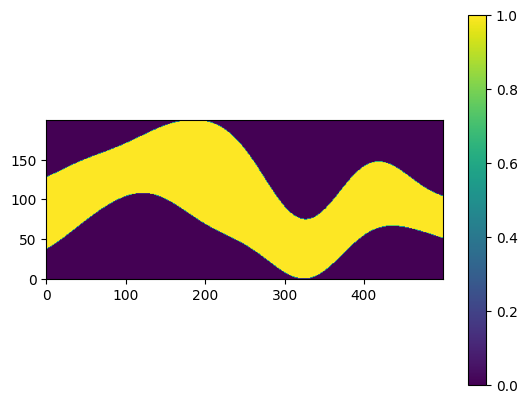

In [28]:
a = np.zeros(nx * nz)
a[sel_indices] = 1.0
plt.imshow(a.reshape(nx, nz, order="F").T, origin="lower")
plt.colorbar()

In [29]:
from pyrtid.inverse import SubSelector, GDPNCS, ChainedTransforms, InvAbsTransform

In [30]:
from pyrtid.utils.spde import simu_nc

res = simu_nc(cholQ_nc)
# plt.imshow(res.reshape(nx, nz, order="F").T)

In [31]:
pcd = ChainedTransforms(
    (
        SubSelector(sel_indices, field_size=nx * nz),
        InvAbsTransform(),
        GDPNCS(
            100,
            Q_nc=Q_nc,
            estimated_mean=200.0,
            cholQ_nc=cholQ_nc,
            random_state=2309,
        ),
    )
)

In [32]:
scond = pcd.transform(np.ones((nx, nz)) * 2.0)
scond.shape

(100,)

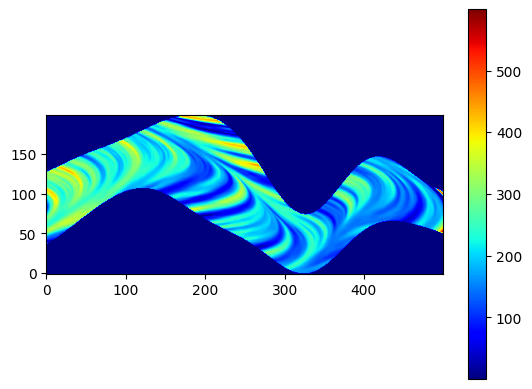

In [33]:
plt.imshow(
    pcd.backtransform(scond).reshape(nx, nz, order="F").T,
    origin="lower",
    cmap=plt.get_cmap("jet"),
)
plt.colorbar()

## Kriging

Creating a set of fictitious wells (extracted from the non-conditional simulation)

In [34]:
db_sample = make_well(db, dbgrid, nwell=nwell, vlag=vlag, seed=seedw)

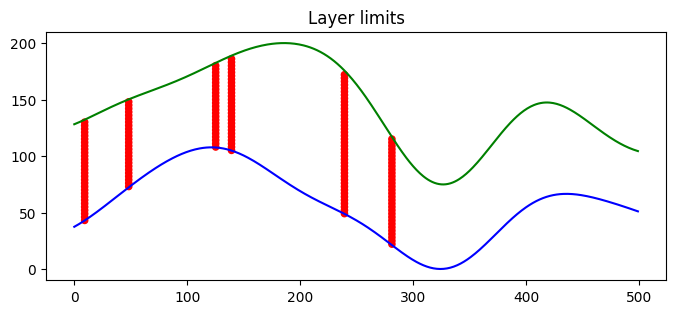

In [35]:
ax = gp.grid1D(db, name="bot_limit_z", color="blue")
ax = gp.grid1D(db, name="top_limit_z", color="green")
ax = gp.point(db_sample, nameCoorY="x2")
ax.decoration(title="Layer limits")

In [36]:
cgParam = gl.CGParam(5000)
spdeParam = gl.SPDEParam()
spdeParam.setCGparams(cgParam)
spdeRes = gl.SPDE(
    model=model,
    domain=dbgrid,
    data=db_sample,
    calcul=gl.ESPDECalcMode.KRIGING,
    mesh=mesh,
    useCholesky=-1,
    params=spdeParam,
)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 100000
Number of active samples     = 43700

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        500       200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = sel - Locator = sel
Column = 4 - Name = aniso - Locator = nostat1
Column = 5 - Name = ratio - Locator = nostat2
Column = 6 - Name = spde.simu - Locator = NA
Column = 7 - Name = spde.estim - Locator = z1
 

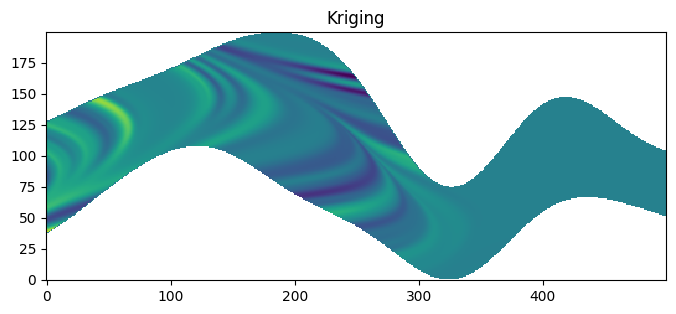

In [37]:
iuid = spdeRes.compute(dbgrid, namconv=gl.NamingConvention("spde", False))
dbgrid.display()
ax = dbgrid.plot("spde.estim")
ax.decoration(title="Kriging")

## Conditional Simulation

In [38]:
spdeRes = gl.SPDE(
    model=model,
    domain=dbgrid,
    data=db_sample,
    calcul=gl.ESPDECalcMode.SIMUCOND,
    mesh=mesh,
)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 9
Total number of samples      = 100000
Number of active samples     = 43700

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        500       200

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = sel - Locator = sel
Column = 4 - Name = aniso - Locator = nostat1
Column = 5 - Name = ratio - Locator = nostat2
Column = 6 - Name = spde.simu - Locator = NA
Column = 7 - Name = spde.estim - Locator = NA
Column = 8 - Name = spde.condsimu - Locator = z1
 

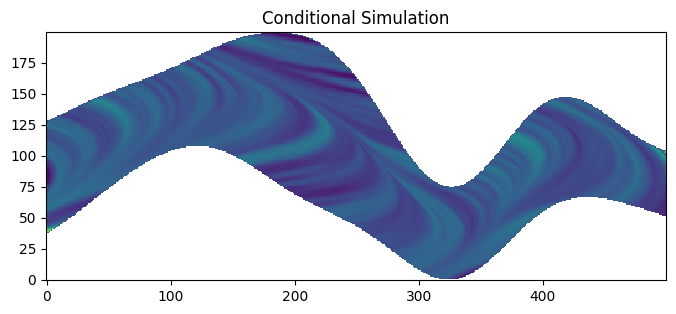

In [39]:
iuid = spdeRes.compute(dbgrid, namconv=gl.NamingConvention("spde.condsimu", False))
dbgrid.display()
ax = dbgrid.plot("spde.condsimu")
ax.decoration(title="Conditional Simulation")